In [2]:
import numpy as np
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage import io
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [3]:
# Load and preprocess images consistently
data = []
label = []

# Adjust this path to where your images are stored
image_paths = glob.glob('./train2/*/*.jpg')

# Process all images in the directory
for image_path in tqdm(image_paths, desc="Processing Images"):
    image = io.imread(image_path)
    img_gray = rgb2gray(image)
    img_resized = resize(img_gray, (128, 128), anti_aliasing=True)
    img_normalized = img_resized / 255.0  # Normalize before flattening
    img_flattened = img_normalized.flatten()
    data.append(img_flattened)
    label.append(1 if 'cat' in image_path else 0)

# Convert lists to NumPy arrays
data = np.array(data)
label = np.array(label)

print(f"Data shape: {data.shape}, Label shape: {label.shape}")


Processing Images: 100%|██████████████████████████████████████████████████████████| 4002/4002 [00:23<00:00, 166.83it/s]


Data shape: (4002, 16384), Label shape: (4002,)


In [ ]:
# Split the data for training and testing (for SVM)
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=42)

# Train the SVM classifier
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)
print("Model training completed!")

# Evaluate the SVM classifier
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


In [ ]:
# Reshape data for CNN (adding a channel dimension for grayscale images)
X_cnn = data.reshape(-1, 128, 128, 1)  # Shape: (num_samples, 128, 128, 1)

# Use binary labels as they are, since it's a binary classification problem
y_cnn = label

# Split the data for training and testing (for CNN)
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_cnn, test_size=0.3, random_state=42)


In [ ]:
# Data augmentation to balance and generalize the data
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train_cnn)

In [ ]:
# Define the CNN model architecture
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

cnn_model = Sequential([
    Input(shape=(128, 128, 1)),  # Explicitly define the input shape here
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()


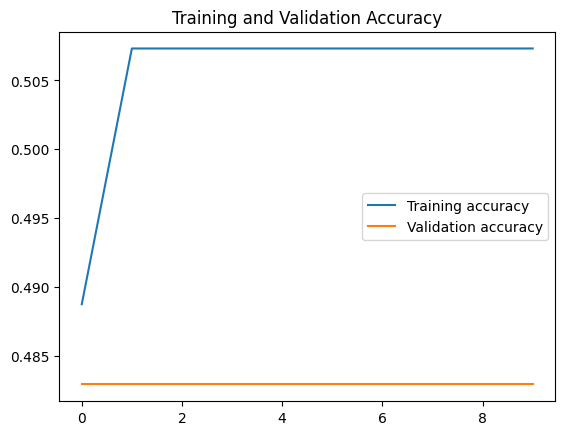

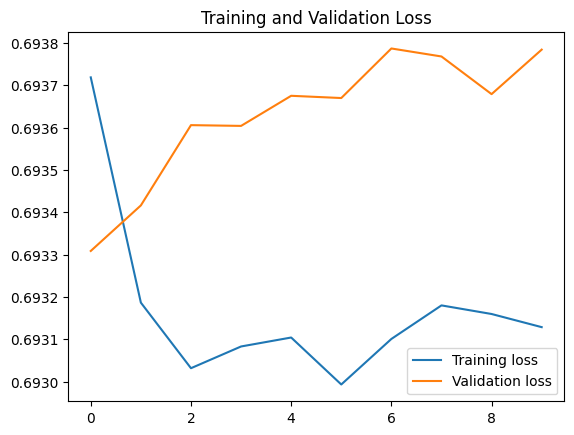

In [78]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [79]:
# Train the CNN model
history = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_test_cnn, y_test_cnn),
    epochs=3,
    batch_size=32
)


Epoch 1/3
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.4672 - loss: 0.6934 - val_accuracy: 0.4829 - val_loss: 0.6933
Epoch 2/3
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.5085 - loss: 0.6931 - val_accuracy: 0.4829 - val_loss: 0.6935
Epoch 3/3
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.5042 - loss: 0.6931 - val_accuracy: 0.4829 - val_loss: 0.6935


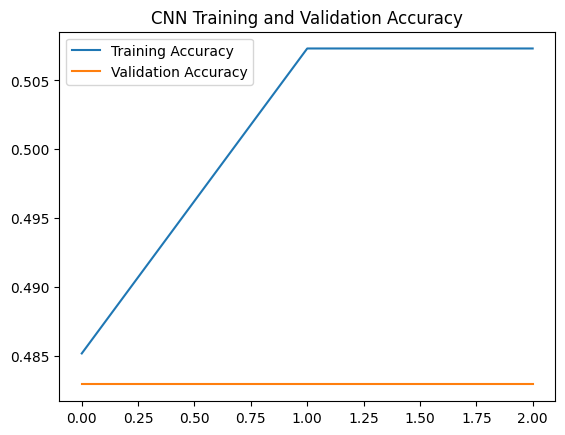

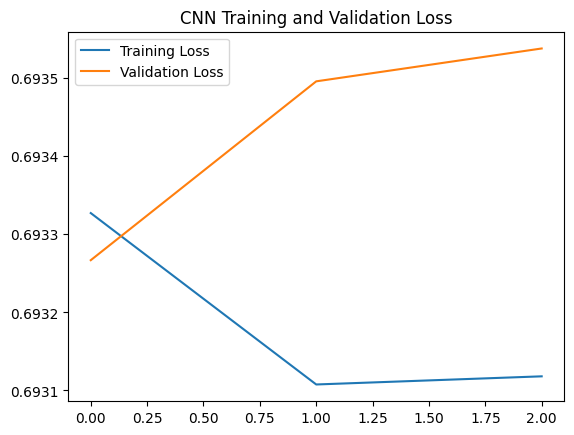

In [80]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Training and Validation Loss')
plt.legend()
plt.show()


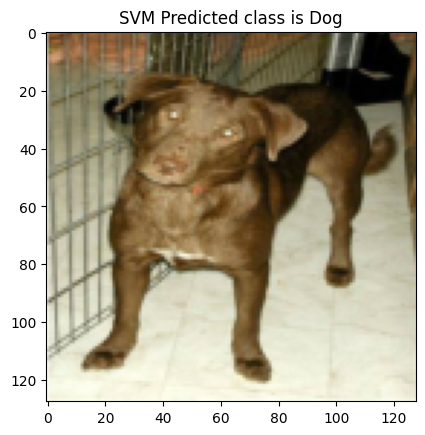

In [81]:
# Example prediction with SVM
def process_image(image_path):
    img = io.imread(image_path)
    img_gray = rgb2gray(img)
    img_resized = resize(img_gray, (128, 128), anti_aliasing=True)
    img_normalized = img_resized / 255.0
    img_flattened = img_normalized.flatten()
    return img_flattened

# Predict with SVM
image_path = './train2/dog/dog.1.jpg'  # Adjust this path for your test image
processed_image = process_image(image_path)
predicted_svm = clf.predict([processed_image])[0]

# Display the processed test image and its prediction from SVM
plt.imshow(resize(io.imread(image_path), (128, 128), anti_aliasing=True), cmap='gray')
plt.title(f'SVM Predicted class is {"Cat" if predicted_svm == 1 else "Dog"}')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


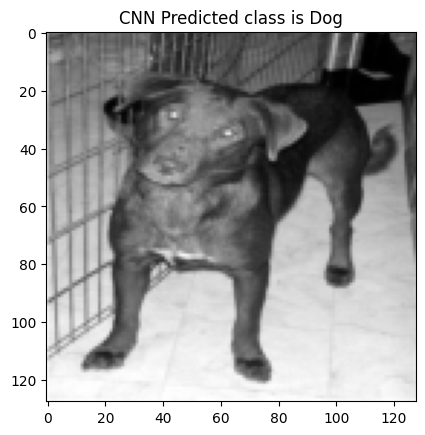

In [82]:
# Predict with CNN
processed_image_cnn = processed_image.reshape(1, 128, 128, 1)  # Reshape for CNN input
predicted_cnn = cnn_model.predict(processed_image_cnn)
predicted_class_cnn = 'Cat' if predicted_cnn[0] > 0.5 else 'Dog'

# Display the processed test image and its prediction from CNN
plt.imshow(processed_image.reshape(128, 128), cmap='gray')  # Display without the channel dimension
plt.title(f'CNN Predicted class is {predicted_class_cnn}')
plt.show()
